In [89]:
import re
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
import nltk
from nltk.stem import PorterStemmer

def goodRating(row):
    return row >= 3

def avgSentiment(row, w_dict):
    s = 0
    tokens = row.split()
    for t in tokens:
         s += w_dict[t]
    return s/len(tokens)


# Porter stemmer for text stemming
porter = PorterStemmer()

stop = ["i", "me", "my", "myself", "we", "our", "ours", "ourselves", 
        "you", "your", "yours", "yourself", "yourselves", "he", "him", "his", "himself", 
        "she", "her", "hers", "herself", "it", "its", "itself", "they", 
        "them", "their", "theirs", "themselves", "what", "which", "who", "whom", "this", 
        "that", "these", "those", "am", "is", "are", "was", "were", "be", "been", "being", 
        "have", "has", "had", "having", "do", "does", "did", "doing", "a", "an", "the", 
        "and", "but", "if", "or", "because", "as", "until", "while", "of", "at", "by", 
        "for", "with", "about", "against", "between", "into", "through", "during", "before", 
        "after", "above", "below", "to", "from", "up", "down", "in", "out", "on", "off", 
        "over", "under", "again", "further", "then", "once", "here", "there", "when", 
        "where", "why", "how", "all", "any", "both", "each", "few", "more", "most", 
        "other", "some", "such", "no", "nor", "not", "only", "own", "same", "so", "than", 
        "too", "very", "s", "t", "can", "will", "just", "don", "should", "now"]

def avg_word(sentence):
    words = sentence.split()
    return (sum(len(word) for word in words)/len(words))

data = pd.read_csv("beer.csv")
data.drop('index',axis =1, inplace = True)
newCols = [col.split('/')[1] for col in data.columns]
data = pd.DataFrame(data.values, columns = newCols).drop(['beerId','brewerId'], axis = 1)

train = data
# Additional featureW
train['word_count'] = train['text'].apply(lambda x: len(str(x).split(" ")))
train['char_count'] = train['text'].str.len() ## this also includes spaces
train['avg_word_len'] = train['text'].apply(lambda x: avg_word(str(x)))
train['stopwords'] = train['text'].apply(lambda x: len([x for x in str(x).split() if x in stop]))
train['questions'] = train['text'].apply(lambda x: len([x for x in str(x).split() if '?' in str(x)]))
train['ellipses'] = train['text'].apply(lambda x: len([x for x in str(x).split() if '...' in str(x)]))
train['numerics'] = train['text'].apply(lambda x: len([x for x in str(x).split() if x.isdigit()]))
train['upper'] = train['text'].str.findall(r'[A-Z]').str.len()
# Convert reviews to lower case
train['text'] = train['text'].apply(lambda x: " ".join(x.lower() for x in str(x).split()))

# Remove punctuation characters from  text review
train['text'] = train['text'].str.replace('[^\w\s]','')
# Remove stop words
train['text'] = train['text'].apply(lambda x: " ".join(x for x in str(x).split() if x not in stop))


In [90]:
# Stem words
train['text'] = train['text'].apply((lambda x: " ".join(porter.stem(x) for x in str(x).split())))

# Remove least frequent words
l_freq = pd.Series(' '.join(train['text']).split()).value_counts()[-10:]
l_freq = list(l_freq.index)
train['text'] = train['text'].apply(lambda x: " ".join(x for x in str(x).split() if x not in l_freq))

# Label beer ratings as positive or negative
train['target'] = train['overall'].apply(goodRating)
train.sort_values(by = 'overall', ascending = False, inplace = True)

In [91]:
text_train = train['text'].values
target = train['target'].values

In [92]:
#Vectorize words from beer rating text
cv = CountVectorizer(binary=True)
cv.fit(text_train)
X = cv.transform(text_train)
#X_test = cv.transform(reviews_test_clean)


In [93]:
X_train, X_val, y_train, y_val = train_test_split(
    X, target, train_size = 0.75
)

c_values = np.linspace(.01,1,100)
accuracy = []
for c in c_values:
    lr = LogisticRegression(C=c, solver='liblinear')
    lr.fit(X_train, y_train)
    
    #print ("Accuracy for C=%s: %s" 
          # % (c, accuracy_score(y_val, lr.predict(X_val))))
    accuracy.append(accuracy_score(y_val, lr.predict(X_val)))
    

/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2069: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


Best C Value: 0.08


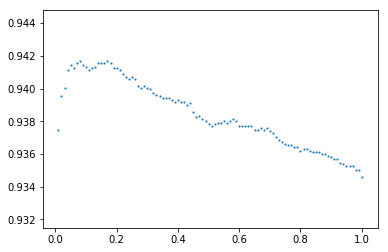

In [94]:
# Optimize the C hyperparameter for regularization 
import matplotlib.pyplot as plt
fig = plt.figure()
plt.scatter(c_values, accuracy, s = 1.2)
best_c = c_values[accuracy.index(max(accuracy))]
print('Best C Value:', best_c)

In [95]:
final_model = LogisticRegression(C = best_c, solver = 'liblinear')
final_model.fit(X, target)

LogisticRegression(C=0.080000000000000002, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [96]:
feature_to_coef = {
    word: coef for word, coef in zip(
        cv.get_feature_names(), final_model.coef_[0]
    )
}
for best_positive in sorted(
    feature_to_coef.items(), 
    key=lambda x: x[1], 
    reverse=True)[:5]:
    print (best_positive)

('easi', 1.1442171602739102)
('smooth', 0.73025998703881134)
('awesom', 0.71731967136557739)
('tasti', 0.70110440377329353)
('session', 0.65562963673971519)


In [97]:
for best_negative in sorted(
    feature_to_coef.items(), 
    key=lambda x: x[1])[:5]:
    print (best_negative)

('drain', -1.0297728795006211)
('drainpour', -0.82669441150241363)
('worst', -0.79515811726745633)
('aw', -0.77419194432958849)
('chemic', -0.74294626132486596)


In [103]:
def avgSentiment(row, w_dict):
    s = 0
    count = 0
    tokens = row.split()
    for t in tokens:
        try:
            s += w_dict[t]
            count += 1
        except:
            continue
    return s/count

In [104]:
train['avg_sent'] = train['text'].apply(avgSentiment, args = (feature_to_coef,))

In [108]:
train.sort_values(by = 'avg_sent', ascending = False).head(5)

,ABV,name,style,appearance,aroma,overall,palate,taste,text,timeStruct,...,word_count,char_count,avg_word_len,stopwords,questions,ellipses,numerics,upper,target,avg_sent
15679,5.2,Herr Kevin's Alt Bier,Altbier,4,3.5,4,3.5,4,excel beer nice dark color bit lighter brown a...,"{'min': 28, 'hour': 14, 'mday': 9, 'sec': 28, ...",...,54,257.0,3.777778,22,0,0,0,4.0,True,0.265601
2864,4.3,Lager,American Pale Lager,3,3.5,3.5,4,3.5,pour nice blond straw color nice crisp scent g...,"{'min': 49, 'hour': 1, 'mday': 16, 'sec': 46, ...",...,61,317.0,4.213115,22,0,0,0,7.0,True,0.255535
13691,5.5,Old Slugger,American Pale Ale (APA),4,4,4,3,4,classic pale nice subtl hop profil good sessio...,"{'min': 57, 'hour': 14, 'mday': 24, 'sec': 1, ...",...,10,60.0,5.100000,0,0,0,0,3.0,True,0.247177
32206,4.6,Strike Out Stout,English Stout,3.5,3.5,3.5,3.5,4,good stout black thick chewi brew six malt smo...,"{'min': 37, 'hour': 22, 'mday': 21, 'sec': 21,...",...,20,100.0,4.500000,4,0,0,0,3.0,True,0.232103
22978,5.6,E.S.B.,Extra Special / Strong Bitter (ESB),4,4,4.5,4.5,4,nice esb wonder copper color excel lace nice m...,"{'min': 24, 'hour': 14, 'mday': 9, 'sec': 14, ...",...,56,293.0,4.250000,22,0,0,0,13.0,True,0.220020
